In [1]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = 'home/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))
now = str(current_milli_time())

def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    """
    Function for simple time series normalization 
    """
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
    return norm_close


def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
        
    return fs

def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))    

In [2]:
#get freq. signal df
fs = get_freq_sig(bw_location)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
print(fs_c.head(3))
print(fs_c.tail(3))
#Create start and end for interval dataframe 
st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)

#30d interval for portfolio generation
intv = 30
#make multiindex frequency dataframe 
#works on fs_c
freq_df,intv_list = interval(intv,st,end)
#group by Coin
cgroups = freq_df.groupby('Coin')
#make list of all syms/dates in dataframe.... the index
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
dates = list(freq_df.index.get_level_values('Date').drop_duplicates())

print(coins)
#test print of grouped dataframe
coin = cgroups.get_group(coins[0])
coin

0% of files loaded
2018-08-24 00:09:22.289000 2019-01-09 18:21:31.239000
2019-01-16 01:56:05.292000 1547621765292
12898    1535083762289
26843    1535084106238
6589     1535084444624
14497    1535084787792
20854    1535085130313
Name: 0, dtype: int64
87228 87228
                                Close         Date_m  rolling_freq
Date                Coin                                          
2018-08-24 04:09:22 ENGBTC   0.000099  1535083762289             1
                    DASHBTC  0.021344  1535083762289             1
2018-08-24 04:15:06 ENGBTC   0.000099  1535084106238             2
                                Close         Date_m  rolling_freq
Date                Coin                                          
2019-01-09 23:15:41 EDOBTC   0.000234  1547075741901           591
                    PIVXBTC  0.000222  1547075741901          1367
2019-01-09 23:21:31 PIVXBTC  0.000222  1547076091239          1368
2018-08-24   |   2018-09-23
2018-09-23   |   2018-10-23
2018-10-23 

,,Close,Date_m,rolling_freq
Date,Coin,,,
2018-08-24 04:09:22,DASHBTC,0.021344,1535083762289,1
2018-08-24 04:32:10,DASHBTC,0.021321,1535085130313,2
2018-08-24 04:37:52,DASHBTC,0.021328,1535085472239,3
2018-08-24 10:01:29,DASHBTC,0.021227,1535104889339,4
2018-08-24 10:07:11,DASHBTC,0.021227,1535105231536,5
2018-08-24 10:18:33,DASHBTC,0.021227,1535105913441,6
2018-08-24 10:24:08,DASHBTC,0.021287,1535106248919,7
2018-08-24 11:04:06,DASHBTC,0.021226,1535108646388,8
2018-08-24 11:09:55,DASHBTC,0.021280,1535108995600,9


# BW freq signal visualization

-used time delta between singal events for smoothing signal and creating tradable actions

1540 28516


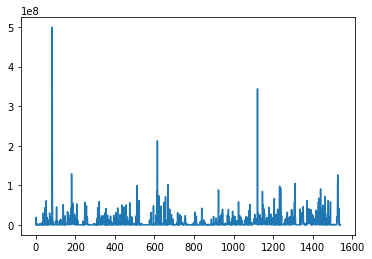

In [3]:
#print(coins)
#utc intervals for ranking event/possible event weighting
d = 86400
h = int(d/24)
hhr = int(h/17)
print(len(coin),len(dates))

t_dif = []
for i in range(0,len(coin)-1):
    t1 = coin['Date_m'].iloc[i]
    t2 = coin['Date_m'].iloc[i+1]
    td = (t2-t1)
    #if(td) signal logic
    t_dif.append(td)
t_dif.append(0)
t_dif_x = [x for x in range(len(t_dif))]
plt.plot(t_dif_x,t_dif)

plt.show()

## Daily resampling for signal/event generation

### creates a dataframe for all coins w/ signals for trading/backtesting
Makes a single csv w/ all coins and multilevel indexing by portfolio time
https://alphascientist.com/feature_engineering.html

In [4]:
all_coins = pd.DataFrame()
for sym in coins:
    coin = cgroups.get_group(sym)
    
    #the secret sauce, extracting value from our data
    #for this example im using the time difference between the signal event occurence to determine enter/exits
    t_dif = []
    for i in range(0,len(coin)-1):
        t1 = coin['Date_m'].iloc[i]
        t2 = coin['Date_m'].iloc[i+1]
        td = (t2-t1)
        #if(td) signal logic
        t_dif.append(td)
    t_dif.append(0)
    #print(t_dif==coin['t_diff'])
    coin = coin.assign(t_dif = t_dif)
    coin.t_dif = coin.t_dif.shift(1)
    
    coin = coin.fillna(method='bfill')
    coin.t_dif = coin.t_dif.pct_change()
    coin = coin[['Close','t_dif']].copy()
    coin.Close = normalize(coin)
    coin.fillna(method='bfill')
    
    #make copy w/ no index for resample and hist data sync
    #create daily signals from intraday signal dataset
    dc = coin.reset_index().copy()
    dc.index = dc.Date
    #Daily resample
    daily_coin = dc.resample('D').sum()
    
    #daily resampled date index
    dates = list(daily_coin.index)
    print(sym)
    print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
    prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)
    
    #Download historical data
    c_hist = get_data(sym,prev_k,k,candle_k='1d')
    
    #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
    c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)
    c_hist['bw_sig'] = daily_coin.t_dif
    c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
    c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
    c_hist = c_hist.fillna(0) 
    c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
    """
    #Visualize trading range and signal
    c_hist2 = c_hist[["Close","sig3"]].copy()
    c_hist2.Close = normalize(c_hist2,deci=True)
    c_hist2["High"] = normalize(c_hist,column="High",deci=True)
    c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
    c_hist2.plot(figsize=(8,5))
    #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))
    
    c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
    """


    c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
    c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
    c_hist['Coin'] = sym
    c_hist = c_hist.reset_index()
    c_hist = c_hist.set_index(['Open time','Coin'])

    all_coins = pd.concat([all_coins,c_hist])
    
#dts is dates for resampled df
dts = all_coins.index.get_level_values(0)

fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
print(fol)
#save all_coin to csv
fname = '/home/me/Documents/BWA/data/bw_portfolios/{}'.format(fol)
if os.path.exists(fname) == False:
    os.mkdir(fname)
    all_coins.to_csv(fname+"{}_day_int.csv".format("30"))

all_coins

DASHBTC
2018-08-24    |    2019-01-09
ENGBTC
2018-08-24    |    2019-01-09
THETABTC
2018-08-24    |    2019-01-09
APPCBTC
2018-08-24    |    2019-01-07
GVTBTC
2018-08-24    |    2019-01-09
OAXBTC
2018-08-24    |    2019-01-09
AIONBTC
2018-08-24    |    2019-01-07
HCBTC
2018-08-24    |    2019-01-09
WINGSBTC
2018-08-24    |    2018-12-31
POLYBTC
2018-08-24    |    2019-01-09
ARDRBTC
2018-08-24    |    2019-01-09
ZENBTC
2018-08-24    |    2019-01-09
CMTBTC
2018-08-24    |    2019-01-04
IOTABTC
2018-08-24    |    2019-01-09
NEBLBTC
2018-08-24    |    2019-01-09
ETHBTC
2018-08-24    |    2019-01-09
ICXBTC
2018-08-24    |    2019-01-08
LOOMBTC
2018-08-24    |    2019-01-09
NANOBTC
2018-08-24    |    2019-01-09
REPBTC
2018-08-24    |    2019-01-09
MODBTC
2018-08-24    |    2019-01-09
LSKBTC
2018-08-24    |    2019-01-09
BNBBTC
2018-08-24    |    2019-01-08
VIBEBTC
2018-08-24    |    2019-01-06
ELFBTC
2018-08-24    |    2019-01-09
MANABTC
2018-08-24    |    2019-01-06
WAVESBTC
2018-08-24    |

,,Open,High,Low,Close,Close time,Volume,Close_diff,bw_sig,sig3,daily_returns,Market Returns,Strategy Returns
Open time,Coin,,,,,,,,,,,,
2018-08-24,DASHBTC,0.021539,0.022011,0.021108,0.021704,1.535155e+12,1.917544e+04,0.0,100.705387,1.0,0.007661,NaN,NaN
2018-08-25,DASHBTC,0.021702,0.021817,0.021200,0.021499,1.535242e+12,1.498299e+04,-1.0,174.461872,1.0,-0.009354,-0.009490,-0.009490
2018-08-26,DASHBTC,0.021477,0.021530,0.020856,0.021102,1.535328e+12,2.155820e+04,-1.0,94.187298,1.0,-0.017461,-0.018639,-0.018639
2018-08-27,DASHBTC,0.021089,0.027886,0.021013,0.026598,1.535414e+12,3.928787e+04,1.0,97.220673,1.0,0.261226,0.231468,0.231468
2018-08-28,DASHBTC,0.026593,0.028475,0.024780,0.027409,1.535501e+12,3.884743e+04,1.0,120.439360,1.0,0.030685,0.030035,0.030035
2018-08-29,DASHBTC,0.027362,0.028828,0.026361,0.026581,1.535587e+12,2.747572e+04,-1.0,0.000000,-1.0,-0.028543,-0.030675,-0.030675
2018-08-30,DASHBTC,0.026582,0.026841,0.025465,0.026515,1.535674e+12,1.745567e+04,-1.0,0.000000,-1.0,-0.002521,-0.002486,0.002486
2018-08-31,DASHBTC,0.026465,0.027878,0.026291,0.027698,1.535760e+12,1.870931e+04,1.0,0.000000,-1.0,0.046590,0.043650,-0.043650
2018-09-01,DASHBTC,0.027699,0.031530,0.027638,0.030890,1.535846e+12,3.477433e+04,1.0,0.000000,-1.0,0.115203,0.109072,-0.109072


# Plotting correlation heatmap for all coins.
Used for feature engineering

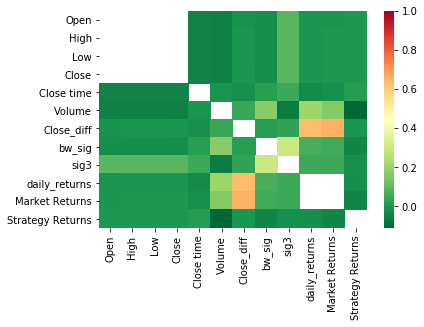

In [5]:
#cgroups = all_coins.groupby('Coin')
corr = all_coins.corr()
#print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r', mask = (corr >= 0.9))

# Show overall perfomance of signal strategy vs BTC benchmark

In [6]:
#Download BTC hist data for benchmark
bench = get_data("BTCUSDT",int(unix_time_millis(dts[0])),int(unix_time_millis(dts[-1])),"1d")

BW Portfolio Returns:

| Avg buy 'n hold: -0.11949372479229904% 
| BW Strategy: 0.45511384397221183% 
| BTC -0.5214415566383174% 

Performance w/ 10,000 starting value

| Avg buy 'n hold: $3590.647185693836 
| BW Strategy: $9336.722873338944
| BTC hold $4785.584433616827


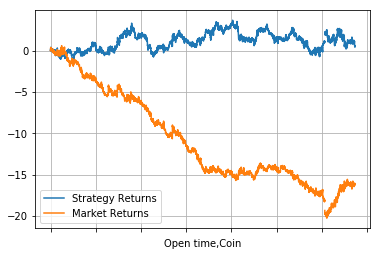

In [7]:
#starting capital
cap = 10000
#make log btc returns
btc = np.log(bench['Close'] / bench['Close'].shift(1))

btc_returns = btc.cumsum().iloc[-1]
s_returns = all_coins['Strategy Returns'].cumsum().iloc[-1]
m_returns = (all_coins['Market Returns'].cumsum().iloc[-1]/len(coins))

#hypothetical returns per strategy
s_value = cap+(cap*s_returns)
m_value = cap+(cap*m_returns)

#hypothetical growth of 10k
btc_value = cap+(cap*btc_returns) 
s_value_usd = cap+(cap*(s_returns+btc_returns))
m_value_usd = cap+(cap*(m_returns+btc_returns))


print("BW Portfolio Returns:\n\n| Avg buy 'n hold: {}% \n| BW Strategy: {}% \n| BTC {}% \n".format(m_returns,s_returns,btc_returns))
print("Performance w/ 10,000 starting value\n\n| Avg buy 'n hold: ${} \n| BW Strategy: ${}\n| BTC hold ${}".format(m_value_usd,s_value_usd,btc_value))
total_returns = all_coins[['Strategy Returns','Market Returns']].cumsum().plot(grid=True)

Portfolio from 2018-08-24 00:00:00 to 2018-09-23 00:00:00 
             DASHBTC
Open time           
2018-08-24  0.021704
2018-08-25  0.021499
2018-08-26  0.021102
2018-08-27  0.026598
2018-08-28  0.027409
             DASHBTC    SUBBTC
Open time                     
2018-08-24  0.021704  0.000024
2018-08-25  0.021499  0.000028
2018-08-26  0.021102  0.000030
2018-08-27  0.026598  0.000028
2018-08-28  0.027409  0.000026
hold
0% [############################# ] 100% | ETA: 00:00:00Stat                 hold
-------------------  ----------
Start                2018-08-23
End                  2018-09-23
Risk-free rate       0.00%

Total Return         1.79%
Daily Sharpe         0.54
Daily Sortino        0.76
CAGR                 23.29%
Max Drawdown         -19.94%
Calmar Ratio         1.17

MTD                  -3.44%
3m                   -
6m                   -
YTD                  1.79%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Ince

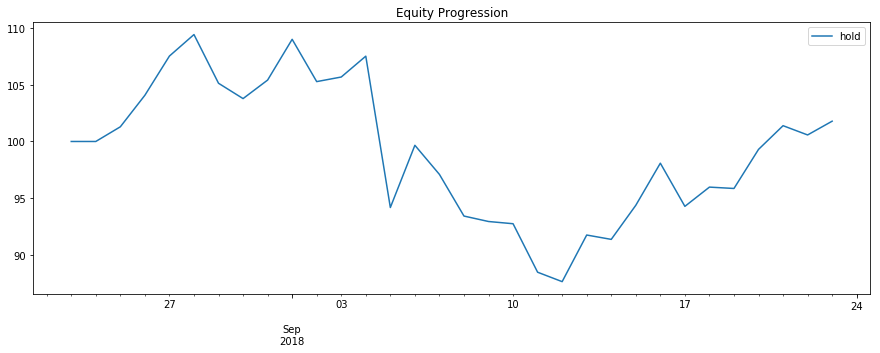

Portfolio from 2018-09-23 00:00:00 to 2018-10-23 00:00:00 
             SALTBTC
Open time           
2018-09-23  0.000077
2018-09-24  0.000072
2018-09-25  0.000073
2018-09-26  0.000071
2018-09-27  0.000073
             SALTBTC   TUSDBTC
Open time                     
2018-09-23  0.000077  0.000149
2018-09-24  0.000072  0.000152
2018-09-25  0.000073  0.000155
2018-09-26  0.000071  0.000155
2018-09-27  0.000073  0.000150
hold
0% [############################# ] 100% | ETA: 00:00:00Stat                 hold
-------------------  ----------
Start                2018-09-22
End                  2018-10-23
Risk-free rate       0.00%

Total Return         16.27%
Daily Sharpe         3.56
Daily Sortino        5.19
CAGR                 490.40%
Max Drawdown         -8.22%
Calmar Ratio         59.67

MTD                  13.91%
3m                   -
6m                   -
YTD                  16.27%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since I

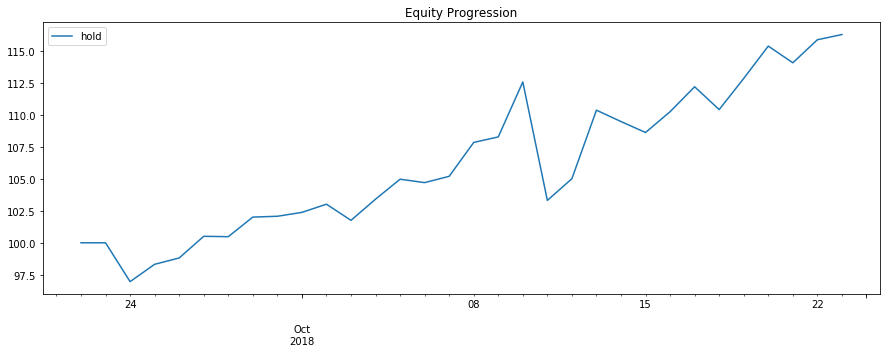

Portfolio from 2018-10-23 00:00:00 to 2018-11-21 00:00:00 
              BCCBTC
Open time           
2018-10-23  0.068525
2018-10-24  0.068230
2018-10-25  0.068240
2018-10-26  0.067901
2018-10-27  0.067718
              BCCBTC
Open time           
2018-10-23  0.068525
2018-10-24  0.068230
2018-10-25  0.068240
2018-10-26  0.067901
2018-10-27  0.067718
hold
0% [######################## ] 100% | ETA: 00:00:00Stat                 hold
-------------------  ----------
Start                2018-10-22
End                  2018-11-15
Risk-free rate       0.00%

Total Return         15.40%
Daily Sharpe         2.18
Daily Sortino        6.13
CAGR                 785.03%
Max Drawdown         -21.16%
Calmar Ratio         37.09

MTD                  17.94%
3m                   -
6m                   -
YTD                  15.40%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  785.03%

Daily Sharpe         2.18
Daily Sortino        6.13

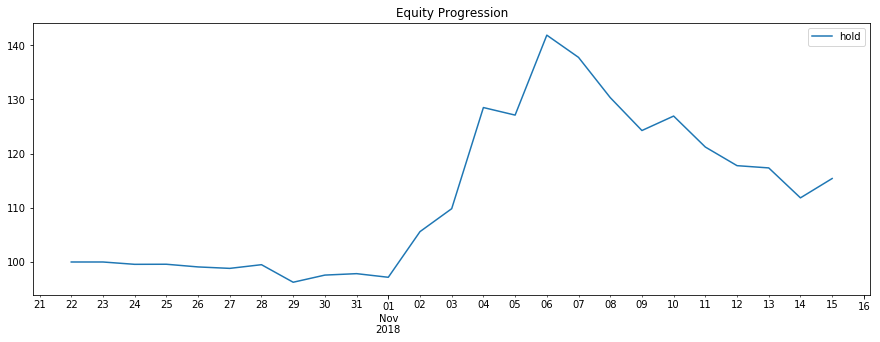

Portfolio from 2018-11-21 00:00:00 to 2018-12-21 00:00:00 
              RDNBTC
Open time           
2018-11-21  0.000062
2018-11-22  0.000060
2018-11-23  0.000059
2018-11-24  0.000059
2018-11-25  0.000056
              RDNBTC    ICXBTC
Open time                     
2018-11-21  0.000062  0.000065
2018-11-22  0.000060  0.000063
2018-11-23  0.000059  0.000063
2018-11-24  0.000059  0.000061
2018-11-25  0.000056  0.000060
hold
0% [############################# ] 100% | ETA: 00:00:00Stat                 hold
-------------------  ----------
Start                2018-11-20
End                  2018-12-21
Risk-free rate       0.00%

Total Return         -1.40%
Daily Sharpe         -0.23
Daily Sortino        -0.33
CAGR                 -15.32%
Max Drawdown         -10.06%
Calmar Ratio         -1.52

MTD                  -2.90%
3m                   -
6m                   -
YTD                  -1.40%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Sinc

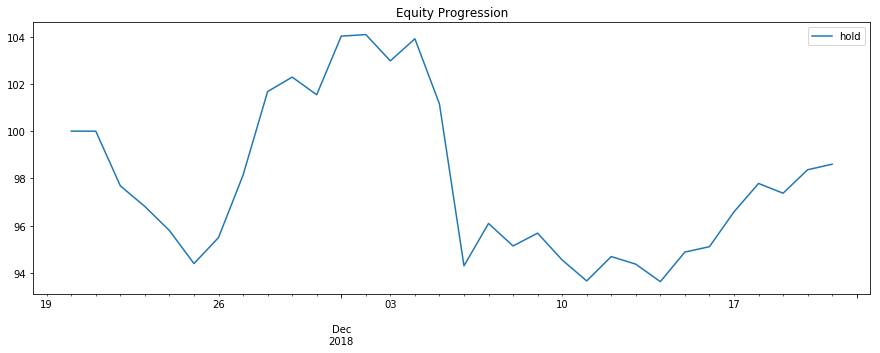

In [16]:
import bt
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w

        # return True because we want to keep on moving down the stack
        return True
    
#bt strategy

hold = bt.Strategy('hold', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

hist_stack = []
pt = "============================"
all_coins = all_coins.sort_values('Open time')
ac_groups = all_coins.groupby('Coin')
for c,t in enumerate(intv_list):
    #1 interval hist dataframe
    bt_hist_data = pd.DataFrame()
    #get start and end dates for interval
    try:
        n = intv_list[c+1]
    except:
        break
    
    print("Portfolio from {} to {} \n{}".format(t,n,pt))
    
    #create copy of df with index selection
    curr = all_coins.loc[t:n].copy()
    curr = curr.reset_index()#.drop_duplicates()
    #list of coin
    coins = curr['Coin'].drop_duplicates()
    curr.index = curr["Open time"]
    idex = curr["Open time"]
    cg = curr.groupby('Coin')
    
    i=0
    prev_len = []
    c_bt = []
    for c in coins:
        curr = cg.get_group(c)
        #print(curr)

        if(i==0):
            prev_len.append(len(curr))

        if(len(curr) == prev_len[len(prev_len)-2]):
            #print(bt_hist_data)
            try:
                bt_hist_data[c] = curr.Close.values
                bt_hist_data.index =curr.index
                prev_len.append(len(curr))
            except Exception as e:
                pass
            
        #bt_hist_data.index = idex.drop_duplicates()  
        #bt_hist_data
        #cont = input("Run backtest? y/n: ")
        #if(cont=='y'):
        #bt_hist_data['Signal'] = curr.sig3
        if(i<2):
            print(bt_hist_data.head())
        i+=1

            
           
    #Monthly holding backtest
    hist_stack.append(bt_hist_data)
    test = bt.Backtest(hold, bt_hist_data)
    res = bt.run(test)
    res.plot()
    res.display()
    plt.show()
    
    



In [17]:
all_c = pd.concat(hist_stack)
all_c

/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,ADABTC,ADXBTC,AEBTC,AGIBTC,AIONBTC,AMBBTC,APPCBTC,ARDRBTC,ARKBTC,ARNBTC,...,XEMBTC,XLMBTC,XMRBTC,XRPBTC,XZCBTC,YOYOBTC,ZECBTC,ZENBTC,ZILBTC,ZRXBTC
Open time,,,,,,,,,,,,,,,,,,,,,
2018-08-24,NaN,NaN,0.000154,NaN,0.000085,0.000020,0.000013,0.000017,0.000122,0.000046,...,NaN,NaN,0.013960,NaN,NaN,NaN,0.021057,0.003082,NaN,0.000109
2018-08-25,NaN,NaN,0.000155,NaN,0.000095,0.000020,0.000013,0.000017,0.000128,0.000044,...,NaN,NaN,0.013735,NaN,NaN,NaN,0.020590,0.002972,NaN,0.000106
2018-08-26,NaN,NaN,0.000154,NaN,0.000095,0.000021,0.000014,0.000016,0.000127,0.000044,...,NaN,NaN,0.014118,NaN,NaN,NaN,0.020178,0.002877,NaN,0.000106
2018-08-27,NaN,NaN,0.000162,NaN,0.000098,0.000022,0.000015,0.000016,0.000132,0.000045,...,NaN,NaN,0.015272,NaN,NaN,NaN,0.022007,0.002901,NaN,0.000117
2018-08-28,NaN,NaN,0.000172,NaN,0.000093,0.000024,0.000016,0.000017,0.000134,0.000050,...,NaN,NaN,0.015185,NaN,NaN,NaN,0.021735,0.002824,NaN,0.000114
2018-08-29,NaN,NaN,0.000163,NaN,0.000087,0.000024,0.000015,0.000016,0.000141,0.000047,...,NaN,NaN,0.014688,NaN,NaN,NaN,0.021740,0.002684,NaN,0.000113
2018-08-30,NaN,NaN,0.000158,NaN,0.000084,0.000023,0.000014,0.000016,0.000129,0.000045,...,NaN,NaN,0.014791,NaN,NaN,NaN,0.021644,0.002664,NaN,0.000109
2018-08-31,NaN,NaN,0.000165,NaN,0.000085,0.000025,0.000014,0.000016,0.000129,0.000047,...,NaN,NaN,0.016568,NaN,NaN,NaN,0.021234,0.002682,NaN,0.000109
2018-09-01,NaN,NaN,0.000167,NaN,0.000087,0.000025,0.000015,0.000017,0.000130,0.000048,...,NaN,NaN,0.016875,NaN,NaN,NaN,0.022000,0.002685,NaN,0.000112
